##**Kasus 1: Menghadapi Tantangan di PT Minyak Nusantara**

PT Minyak Nusantara, perusahaan minyak goreng yang didirikan pada tahun 1985, menghadapi sejumlah tantangan strategis dan operasional dalam mempertahankan daya saing dan keberlanjutannya. Perusahaan mengalami penurunan penjualan sebesar 15% dan penyusutan pangsa pasar dari 22% menjadi 18% dalam satu tahun terakhir. Tekanan persaingan dari merek impor yang mengklaim "alami" dan "organik" semakin memperumit situasi.

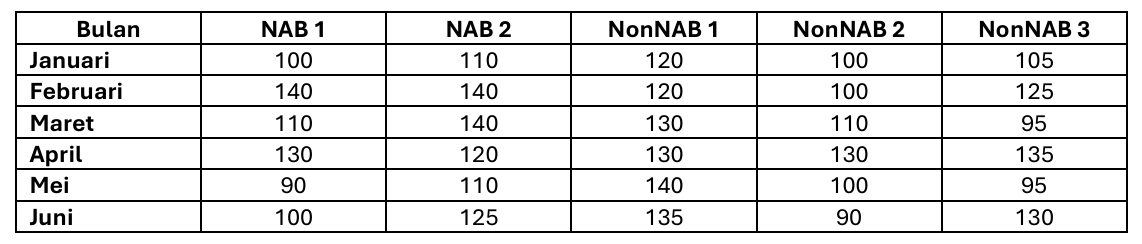

Perusahaan menghadapi tantangan yang kompleks dalam mengoptimalkan rantai pasok dan proses produksinya. Kelima jenis minyak mentah yang digunakan—dua berasal dari kategori nabati (NAB 1 dan NAB 2) dan tiga dari non-nabati (NonNAB 1, NonNAB 2, dan NonNAB 3)—harus diolah dengan rasio khusus yang menjadi rahasia perusahaan. Harga minyak-mentah ini berfluktuasi setiap bulannya seperti ditampilkan pada tabel di atas (dalam ribuan Rp/ton), menambah kompleksitas dalam perencanaan pembelian. Setiap minyak memiliki karakteristik kekentalan berbeda: NAB 1 (8,8), NAB 2 (6,1), NonNAB 1 (2,0), NonNAB 2 (4,2), dan NonNAB 3 (5,0), sementara kombinasi semua minyak harus menghasilkan produk akhir dengan kekentalan antara 3 hingga 6 pada skala perusahaan. Kapasitas produksi terbatas pada 200 ton per bulan untuk minyak nabati dan 250 ton untuk non-nabati, dengan kemampuan penyimpanan minyak mentah maksimal 1000 ton per jenis disertai biaya penyimpanan Rp 5.000 per ton per bulan.

Fluktuasi harga minyak mentah setiap bulan menambah kompleksitas pengambilan keputusan, sementara perusahaan harus menjaga tingkat inventaris sebanyak 500 ton untuk setiap minyak hingga akhir periode. Harga jual produk akhir tetap pada tingkat Rp 150.000 per ton, menuntut efisiensi maksimal dalam seluruh proses.

Tantangan semakin meluas dengan adanya tekanan untuk memenuhi komitmen lingkungan berupa pengurangan jejak karbon 30% dalam lima tahun, pertimbangan ekspansi ke pasar Malaysia, program tanggung jawab sosial terhadap petani kelapa sawit skala kecil, pengembangan produk baru "ultra-sehat", serta isu internal terkait otomatisasi dan keterbatasan keuangan. Keseluruhan situasi menuntut pendekatan terintegrasi yang mampu menyeimbangkan optimasi operasional dengan berbagai tujuan strategis dan konstrain organisasi.

##**Penyelesaian**

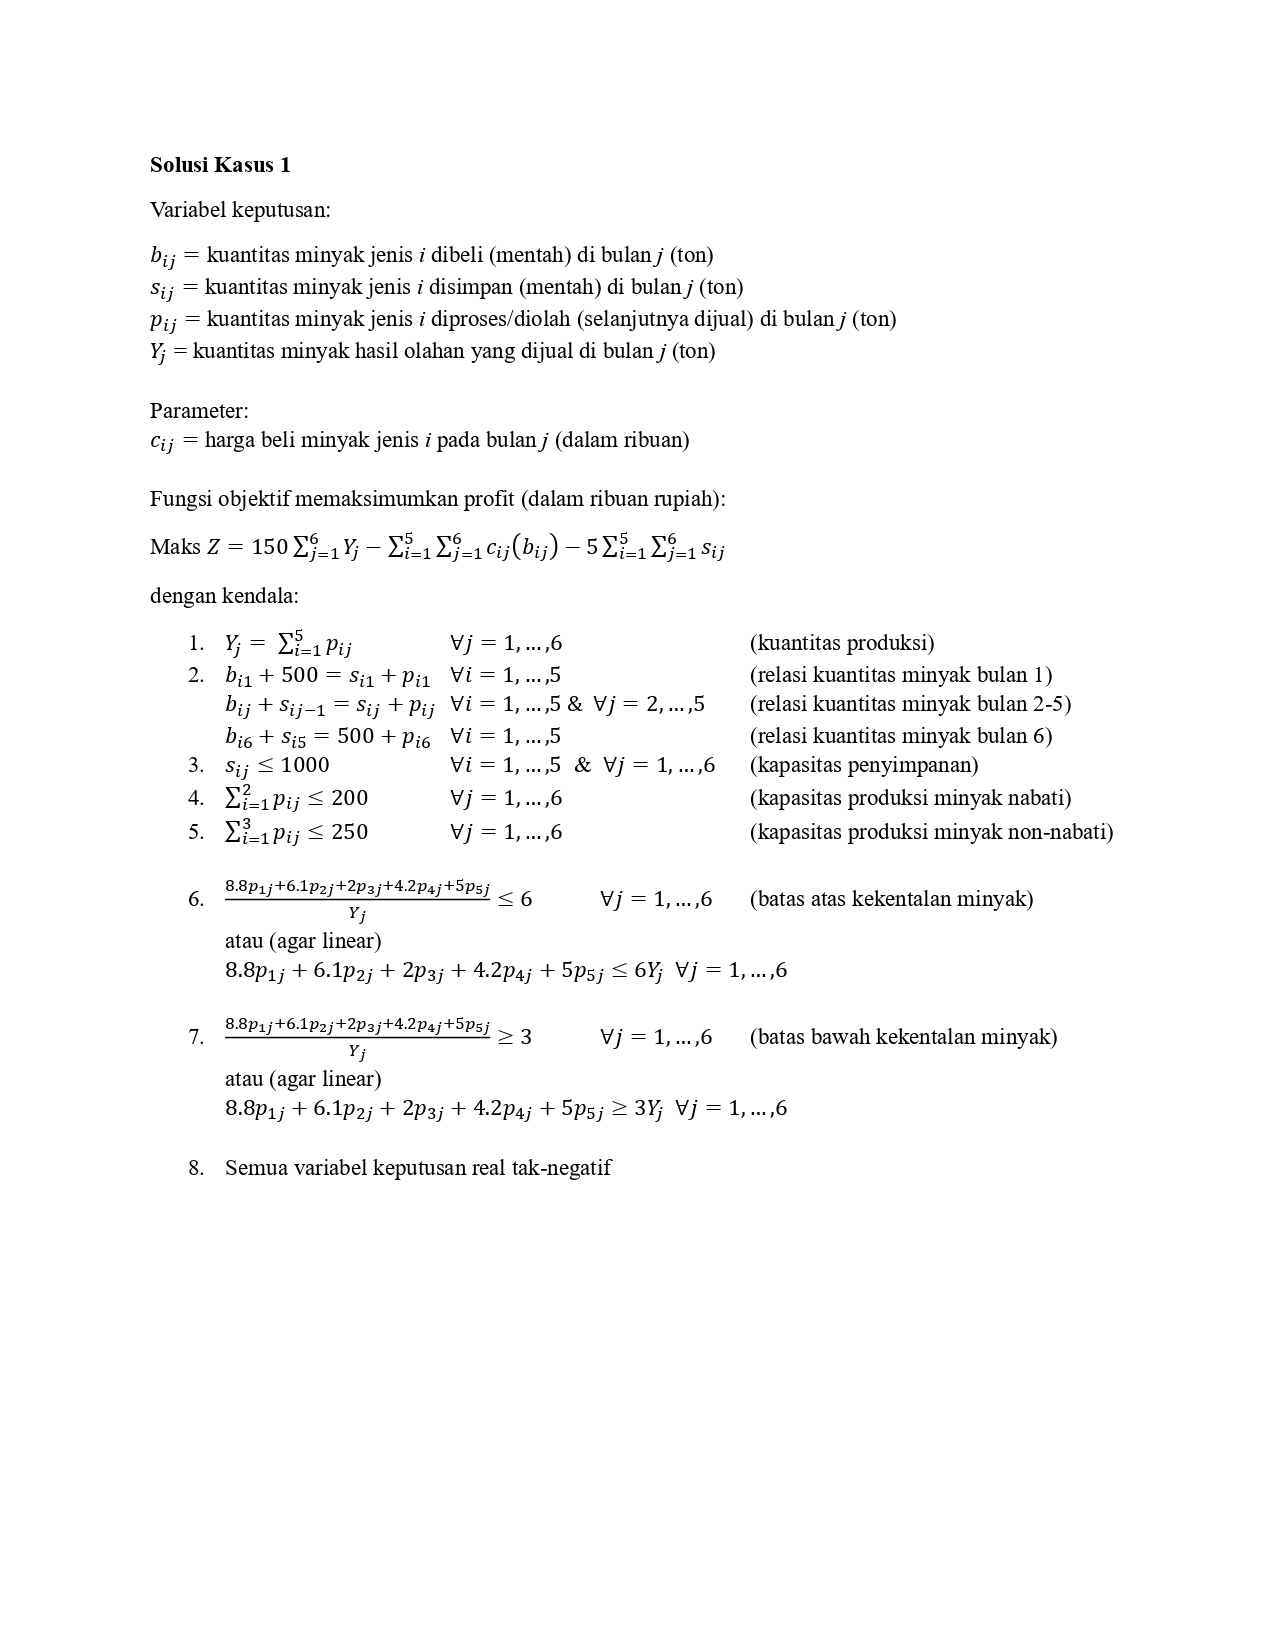

##**Implementasi Pyomo**

In [ ]:
!pip install pyomo
!apt-get install -y -qq glpk-utils

In [ ]:
from pyomo.environ import *

In [ ]:
# Model
model = ConcreteModel()

# Data harga minyak
cost_matrix=[
    [100,140,110,130,90,100],
    [110,140,140,120,110,125],
    [120,120,130,130,140,135],
    [100,100,110,130,100,90],
    [105,125,95,135,95,130]]

# Indeks jenis minyak dan bulan
model.M = RangeSet(1,5)
model.N = RangeSet(1,6)

# Variabel keputusan
model.b = Var(model.M,model.N, within=NonNegativeReals)
model.s = Var(model.M,model.N, within=NonNegativeReals)
model.p = Var(model.M,model.N, within=NonNegativeReals)
model.y = Var(model.N, within=NonNegativeReals)

# Parameter harga minyak cij
model.c = Param(model.M, model.N,initialize=lambda model, i, j: cost_matrix[i-1][j-1])

# Objektif: Memaksimumkan profit (dalam ribuan rupiah)
def obj_func(model):
    return 150*sum(model.y[j] for j in model.N)-sum(model.c[i,j] * model.b[i,j] for i in model.M
           for j in model.N)-5*sum(model.s[i,j] for i in model.M for j in model.N)
model.objective = Objective(rule=obj_func,sense=maximize)

# Kuantitas produksi
def rule_const1(model,N):
    return model.y[N] == sum(model.p[i,N] for i in model.M)
model.const1 = Constraint(model.N,rule=rule_const1)

# Relasi kuantitas minyak bulan 1
def rule_const21(model,M):
    return model.b[M,1] + 500 == model.s[M,1] + model.p[M,1]
model.const21 = Constraint(model.M,rule=rule_const21)

# Relasi kuantitas minyak bulan 2-5
def rule_const22(model,M,N):
    if N!=1&N!=6:
        return model.b[M,N] + model.s[M,N-1] == model.s[M,N] + model.p[M,N]
    else:
        #return nothing (siasat belaka, agar program bekerja)
        return model.b[M,N]==model.b[M,N]
model.const22 = Constraint(model.M,model.N,rule=rule_const22)

# Relasi kuantitas minyak bulan 6
def rule_const23(model,M):
    return model.b[M,6] + model.s[M,5] == 500 + model.p[M,6]
model.const23 = Constraint(model.M,rule=rule_const23)

# Kapasitas penyimpanan
def rule_const4(model,M,N):
    return model.s[M,N] <= 1000
model.const4 = Constraint(model.M,model.N,rule=rule_const4)

# Kapasitas produksi minyak nabati
def rule_const5(model,N):
    return model.p[1,N]+model.p[2,N] <= 200
model.const5 = Constraint(model.N,rule=rule_const5)

# Kapasitas produksi minyak non-nabati
def rule_const6(model,N):
    return model.p[3,N]+model.p[4,N]+model.p[5,N] <= 250
model.const6 = Constraint(model.N,rule=rule_const6)

# Batas atas kekentalan minyak
def rule_const7(model,N):
    return 8.8*model.p[1,N] + 6.1*model.p[2,N] + 2*model.p[3,N] + 4.2*model.p[4,N] + 5*model.p[5,N] <= 6*model.y[N]
model.const7 = Constraint(model.N,rule=rule_const7)

# Batas bawah kekentalan minyak
def rule_const8(model,N):
    return 8.8*model.p[1,N]+ 6.1*model.p[2,N]+ 2*model.p[3,N] + 4.2*model.p[4,N] + 5*model.p[5,N]  >= 3*model.y[N]
model.const8 = Constraint(model.N,rule=rule_const8)

# Penyelesaian - menggunakan solver GLPK
result = SolverFactory('glpk').solve(model)

# Display output nilai variabel keputusan
print(f'Status solusi: {result.solver.termination_condition}')
print(f'Nilai fungsi objektif: {model.objective()}\n')

L1 = list(model.y.keys())
for i in L1:
        print('y',i, '--', model.y[i]())

L2 = list(model.p.keys())
for i in L2:
        print('p',i,model.p[i]())

L3 = list(model.b.keys())
for i in L3:
        print('b',i,model.b[i]())

L4 = list(model.s.keys())
for i in L4:
        print('s',i,model.s[i]())

Status solusi: optimal
Nilai fungsi objektif: 98148.14814814815

y 1 -- 450.0
y 2 -- 450.0
y 3 -- 450.0
y 4 -- 450.0
y 5 -- 450.0
y 6 -- 450.0
p (1, 1) 85.1851851851852
p (1, 2) 85.1851851851852
p (1, 3) 159.259259259259
p (1, 4) 159.259259259259
p (1, 5) 159.259259259259
p (1, 6) 159.259259259259
p (2, 1) 114.814814814815
p (2, 2) 114.814814814815
p (2, 3) 40.7407407407408
p (2, 4) 40.7407407407408
p (2, 5) 40.7407407407408
p (2, 6) 40.7407407407408
p (3, 1) 0.0
p (3, 2) 0.0
p (3, 3) 0.0
p (3, 4) 0.0
p (3, 5) 0.0
p (3, 6) 0.0
p (4, 1) 0.0
p (4, 2) 0.0
p (4, 3) 250.0
p (4, 4) 250.0
p (4, 5) 250.0
p (4, 6) 250.0
p (5, 1) 250.0
p (5, 2) 250.0
p (5, 3) 0.0
p (5, 4) 0.0
p (5, 5) 0.0
p (5, 6) 0.0
b (1, 1) 0.0
b (1, 2) 0.0
b (1, 3) 0.0
b (1, 4) 0.0
b (1, 5) 807.407407407407
b (1, 6) 0.0
b (2, 1) 0.0
b (2, 2) 0.0
b (2, 3) 0.0
b (2, 4) 0.0
b (2, 5) 392.592592592593
b (2, 6) 0.0
b (3, 1) 0.0
b (3, 2) 0.0
b (3, 3) 0.0
b (3, 4) 0.0
b (3, 5) 0.0
b (3, 6) 0.0
b (4, 1) 0.0
b (4, 2) 0.0
b (4, 3) 0.0




---
Berdasarkan hasil solusi optimal model optimasi, PT Minyak Nusantara dapat mencapai keuntungan maksimum sebesar **Rp 98,15 miliar** melalui strategi operasional yang terencana dengan cermat. Solusi ini tidak hanya memenuhi semua kendala operasional tetapi juga mengungkapkan beberapa wawasan strategis penting bagi perusahaan.


**Strategi Produksi**\
Perusahaan mempertahankan produksi konsisten sebesar 450 ton per bulan selama periode enam bulan, namun dengan komposisi bahan baku yang berubah secara strategis:
- Bulan 1-2: Menggunakan kombinasi 85,19 ton NAB 1 (19%), 114,81 ton NAB 2 (25%), dan 250 ton NonNAB 5 (56%)
- Bulan 3-6: Beralih ke kombinasi 159,26 ton NAB 1 (35%), 40,74 ton NAB 2 (9%), dan 250 ton NonNAB 4 (56%)

Pergeseran ini menunjukkan fleksibilitas dalam merespons kondisi pasar dan karakteristik bahan baku.

**Manajemen Rantai Pasok**\
Strategi pembelian yang diterapkan sangat efisien:
- Pembelian terkonsentrasi terutama pada bulan ke-5, memanfaatkan harga yang lebih rendah
- Pembelian besar untuk NAB 1 (807,41 ton), NAB 2 (392,59 ton), NonNAB 4 (250 ton), dan NonNAB 5 (500 ton)
- Manajemen inventori yang optimal dengan pemanfaatan penyimpanan maksimal 659 ton untuk NAB 1 dan 541 ton untuk NAB 2

**Wawasan Strategis**\
Hasil optimasi mengungkap beberapa insight penting:
- Efisiensi biaya: Menghindari penggunaan NonNAB 1 dan NonNAB 3 karena karakteristik kekentalannya tidak optimal
- Strategi pembelian bulk: Memanfaatkan periode harga rendah untuk pembelian dalam jumlah besar
- Fleksibilitas: Kemampuan beralih antara NonNAB 4 dan NonNAB 5 menunjukkan adaptasi terhadap kondisi pasar

Pencapaian profitabilitas setinggi ini membuktikan bahwa pendekatan optimasi dapat secara signifikan meningkatkan kinerja perusahaan meskipun menghadapi penurunan penjualan dan tekanan kompetitif yang berat.